# Fit atmosphere parameters : VAOD, PWV , Ozone

- author Sylvie Dagoret-Campagne
- update August 17th 2020
- update August 18th 2020 : add scaling
- update August 19th 2020 : remove Rayleigh, add Linear (No reg) fit, mag or no mag fit
- update Augist 21th 2020 : add histos and plot routines
- update August 22th 2020 : increase length of learning curves
- update August 24th 2020 : correct bug on learning curves (use full test dataset)


Last verification : December 14th 2021


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
%load_ext autoreload
In [2]: %autoreload 2

In [4]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [5]:
import libatmscattering as atm

In [6]:
# pysynphot
import pysynphot as S
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [7]:
import libPySynPhotSpectra as Spectra

path_sed_calspec= /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/calspec
liblsstfilter_path= /Users/sylvie/MacOSX/GitHub/LSST/PhotomCorrectAuxTel/analysis/MLfit_atm/../../data/lsst/LSSTFiltersKG


In [8]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [9]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3f}'.format(mu),
    '$median$={:.3f}'.format(median),
    '$\sigma$={:.3f}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [10]:
DATADIR="../../data/atm"

In [11]:
atmospheric_basename_files=os.listdir(DATADIR)

In [12]:
atmospheric_basename_files

['lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 'lsst_atm_10year_02.fits']

In [13]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [14]:
hdu = fits.open(input_file)

In [15]:
hdr=hdu[0].header
data=hdu[0].data

In [16]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [17]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [18]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [19]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm_tot=data[1:,idx_out_res:]

### Select wavelength range

In [20]:
WLMINSEL=340.
WLMAXSEL=1100.

In [21]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [22]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [23]:
len(indexes_selected)

760

In [24]:
wl=wl[indexes_selected]
transm_tot=transm_tot[:,indexes_selected]

### Remove rayleigh component

In [25]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [26]:
transm=transm_tot/att_rayleigh

### Not removing Rayleigh

In [27]:
transm=transm_tot

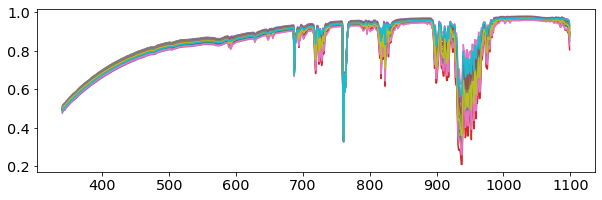

In [28]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,transm[idx,:])

In [29]:
NWL=wl.shape[0]

In [30]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [31]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [32]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

### For Y used mangitude of spectra

In [33]:
t=Spectra.GetListOfCalspec()
t_sel=Spectra.SelectFewSED(t)

In [34]:
t_sel

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float32,float64,float64,float64,bytes27,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_005.fits,13.961,14.593,14.473,14.569,14.723,61.551,-0.250
ALPHA_LYR,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_008.fits,0.021,0.017,0.009,0.000,-0.004,0.00010079,0.013
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_004.fits,7.161,7.036,6.839,6.694,6.589,0.054409,0.251
HD074000,130.212,-16.345,F2,D,9.840,10.090,9.660,100000000000000000000.000,100000000000000000000.000,hd074000_stis_003.fits,9.852,10.065,9.645,9.269,8.987,0.72107,0.658
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_004.fits,8.117,8.020,7.403,6.957,6.653,0.091453,0.750
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


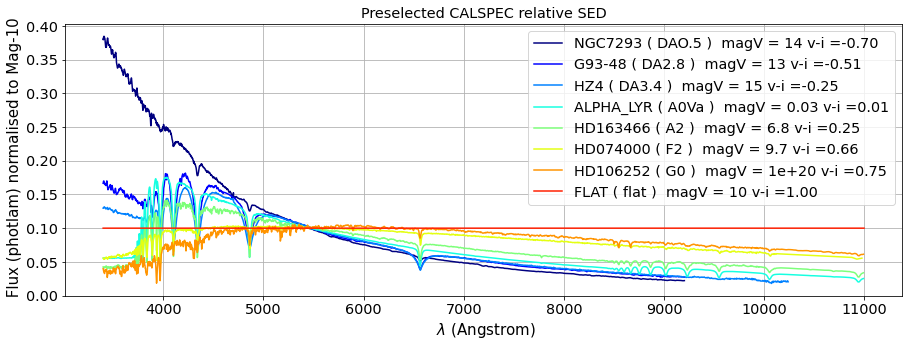

In [35]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
Spectra.plot_sed(t_sel,ax)
plt.show()

## Get the Spectra

In [36]:
idx_sed_sel=4
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
order2=True
if order2:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"

In [37]:
specarrayfile

'spec_HD163466_ord12.npy'

In [38]:
specarrayfile2

'spec2_HD163466_ord2.npy'

In [39]:
sed_fullfilename

'/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/calspec/hd163466_stis_004.fits'

In [40]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.


In [41]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=Spectra.GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2)
    #                        GetSpectra(sed, wl_atm, atm_transmission, order2=False)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(((QE * atm0) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm0) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be us

(((QE * atm32) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm32) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm33) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm33) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm34) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm34) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm35) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm35) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm64) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm64) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm65) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm65) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm66) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm66) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm67) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm67) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm96) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm96) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm97) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm97) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm98) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm98) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm99) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm99) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm127) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm159) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm159) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm160) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm160) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm161) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm161) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm162) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm162) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm190) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm194) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm222) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm222) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm225) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm225) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm253) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm254) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm285) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm285) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm287) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm287) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm288) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm316) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm348) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm379) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm380) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm380) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm381) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm381) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm382) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm382) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm383) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm411) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm411) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm413) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm413) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm442) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm443) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm443) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm444) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm444) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm445) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm445) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm446) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm474) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm474) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm475) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm505) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm506) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm507) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm507) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm508) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm508) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm509) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm537) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm568) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm569) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm572) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm600) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm600) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm601) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm601) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm631) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm632) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm663) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm663) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm666) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm694) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm726) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm757) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm758) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm758) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm759) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm759) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm760) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm760) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm761) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm820) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm821) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm821) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm822) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm822) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm823) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm823) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm824) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm852) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm883) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm884) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm884) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm885) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm885) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm886) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm886) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm887) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm915) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm915) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm917) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm917) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm918) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm918) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm946) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm947) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm947) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm948) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm948) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm949) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm949) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm950) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm978) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm1009) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1010) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1013) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1041) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1041) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1042) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1042) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1043) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1043) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1072) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1073) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1074) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1074) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1075) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1075) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1076) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1106) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1106) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1135) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1136) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1136) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1137) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1139) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1167) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1167) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1198) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1199) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1200) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1200) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1201) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1201) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1202) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1230) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1230) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1232) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1232) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1261) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1263) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1263) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1264) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1264) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1265) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1293) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1293) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1294) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1294) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1295) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1295) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1296) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1296) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1324) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1325) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1325) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1326) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1326) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1328) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1356) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1356) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1357) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1357) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1358) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1358) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1359) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1359) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1387) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1388) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1391) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1419) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1419) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1420) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1420) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1421) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1421) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1422) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1422) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1450) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1451) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1452) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1454) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1482) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1482) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1483) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1483) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1484) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1484) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1485) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1485) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1513) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1517) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1545) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1545) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1546) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1576) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1577) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1580) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1608) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1608) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1609) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1639) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1643) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1671) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1671) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1672) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1672) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1674) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1674) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1702) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1703) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1703) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1704) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1704) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1705) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1705) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1706) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1734) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1734) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1737) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1737) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1769) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1797) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1797) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1798) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1798) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1799) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1799) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1800) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1800) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1828) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1829) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1829) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1832) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1860) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1860) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1891) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1892) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1895) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1923) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1923) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1924) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1924) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1925) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1925) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1954) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1955) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1955) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1956) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1956) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1957) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1958) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1986) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1986) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1989) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1989) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2017) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2019) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2019) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2020) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2020) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2021) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2049) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2049) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2050) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2050) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2051) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2051) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2052) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2052) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2080) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2081) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2081) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2082) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2082) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2083) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2083) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2084) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2112) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2112) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2113) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2113) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2114) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2114) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2115) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2115) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2143) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2147) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2175) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2178) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2178) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2206) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2207) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2207) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2208) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2208) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2209) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2209) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2210) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2238) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2239) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2239) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2240) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2240) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2269) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2270) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2270) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2271) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2271) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2272) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2272) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2273) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2304) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2304) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2332) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2333) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2333) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2334) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2334) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2335) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2335) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2336) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2364) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2395) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2396) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2396) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2397) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2397) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2398) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2398) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2399) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2427) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2427) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2428) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2428) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2429) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2429) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2430) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2430) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2458) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2459) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2460) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2460) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2461) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2461) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2462) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2490) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2490) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2491) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2491) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2492) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2492) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2493) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2521) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2522) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2522) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2523) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2523) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2524) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2524) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2525) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2553) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2553) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2554) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2554) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2555) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2555) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2556) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2556) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2584) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2585) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2585) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2586) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2586) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2587) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2587) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2588) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2616) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2616) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2617) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2617) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2618) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2618) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2619) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2619) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2647) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2649) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2649) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2650) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2650) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2651) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2679) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2679) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2681) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2681) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2710) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2713) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2713) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2714) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2742) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2743) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2743) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2745) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2745) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2773) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2774) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2776) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2776) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2777) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2805) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2805) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2806) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2806) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2807) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2807) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2808) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2808) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2836) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2837) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2837) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2838) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2838) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2839) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2839) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2840) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2868) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2868) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2870) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2870) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2871) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2871) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2899) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2900) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2900) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2901) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2901) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2902) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2902) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2903) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2931) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2931) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2932) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2932) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2933) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2933) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2934) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2934) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2962) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2963) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2963) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2964) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2964) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2965) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2965) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2966) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2994) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2994) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2995) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2995) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2996) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2996) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2997) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2997) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3025) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3026) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3026) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3027) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3027) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3028) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3028) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3029) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3057) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3088) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3089) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3089) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3090) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3090) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3091) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3091) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3092) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3120) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3120) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3121) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3121) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3122) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3123) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3123) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3151) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3152) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3152) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3153) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3153) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3154) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3154) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3155) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3183) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3184) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3184) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3185) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3185) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3214) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3215) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3215) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3216) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3216) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3217) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3217) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3218) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3246) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3246) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3249) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3249) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3279) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3279) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3280) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3280) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3281) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3309) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3309) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3310) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3310) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3311) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3311) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3312) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3312) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3340) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3341) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3341) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3342) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3342) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3344) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3372) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3374) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3374) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3375) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3375) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3403) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3404) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3407) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3435) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3437) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3437) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3438) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3438) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3466) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3467) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3467) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3470) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3498) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3498) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3499) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3499) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3500) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3500) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3501) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3501) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3529) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3530) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3530) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3531) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3531) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3532) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3532) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3533) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3561) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3561) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3592) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3593) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3593) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3596) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3624) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3624) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3625) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3625) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3626) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3626) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3627) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3627) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

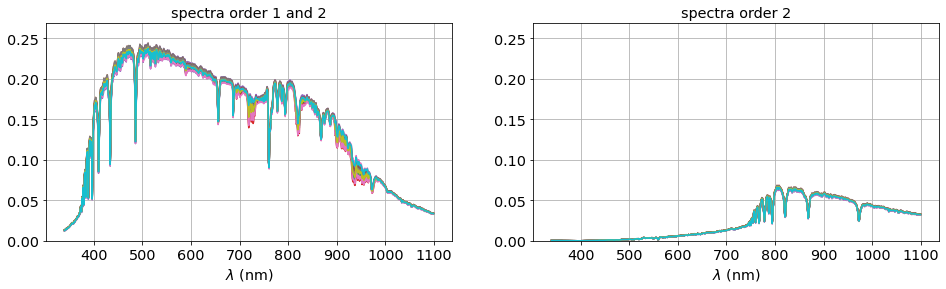

In [42]:
if 1:
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

In [43]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(spectra)
else:
    X=transm
    

Text(0, 0.5, 'magnitude (mag)')

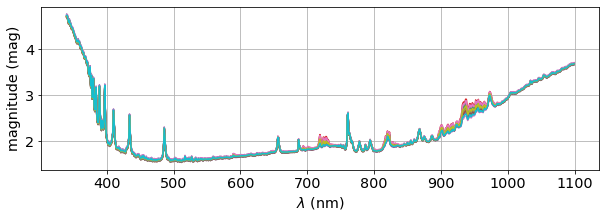

In [44]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,X[idx,:])
ax.grid()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("magnitude (mag)")

## Splitting

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [46]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [47]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [48]:
FLAG_SCALING=True

In [49]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [50]:
scaler_X.mean_.shape

(760,)

In [51]:
scaler_X.scale_.shape

(760,)

In [52]:
scaler_Y.mean_.shape

(3,)

In [53]:
scaler_Y.scale_.shape

(3,)

In [54]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

Text(0.5, 1.0, 'Renormalised target (VAOD, O3, PWV)')

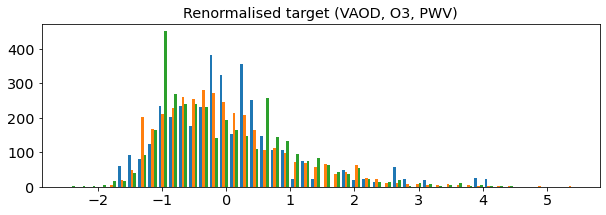

In [55]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV)")

## Linear regression model

In [56]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [57]:
reg = linear_model.LinearRegression()

In [58]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [59]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[-2.23299589e-03 -1.64301066e-02 -1.26729112e-02 ...  4.32944348e+01
  -9.41218648e+00  9.23059495e-01]
 [-5.21307667e-02 -1.98716316e-02 -1.75760093e-02 ...  1.39198025e+02
  -3.10174593e+01  7.92834706e-01]
 [-5.71323749e-02  3.05147710e-01  1.98589719e-01 ... -6.75360455e+02
   1.47189390e+02 -1.32872129e+01]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [60]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [61]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[-0.01686625 -0.01207461 -0.0099757  ...  0.00469765  0.00485633
   0.00489249]
 [ 0.00661091  0.00482402  0.00429076 ...  0.00672816  0.00761906
   0.01261394]
 [ 0.27371254  0.19921908  0.16830557 ... -0.01408436 -0.01552256
  -0.01276993]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [62]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.74622e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87251e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.05472e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.33189e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-c

<Figure size 1080x1080 with 0 Axes>

In [63]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [64]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1.1097524964120698e-10

0.003570785964900463

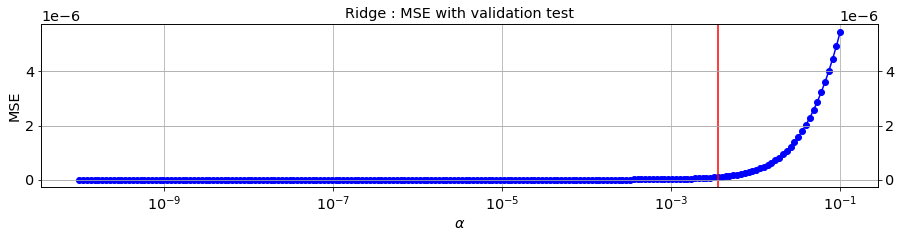

In [65]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE<1e-7)[0][-1]
else:
    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.grid()
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

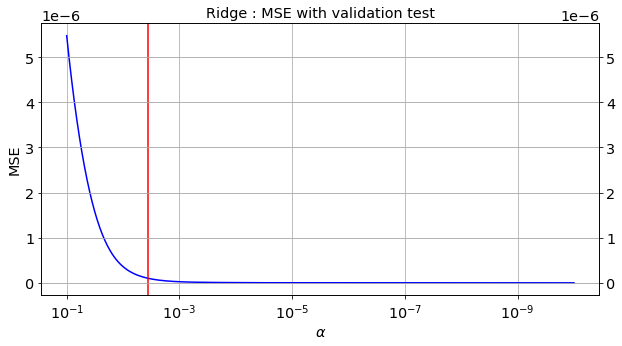

In [66]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
ax.grid()
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

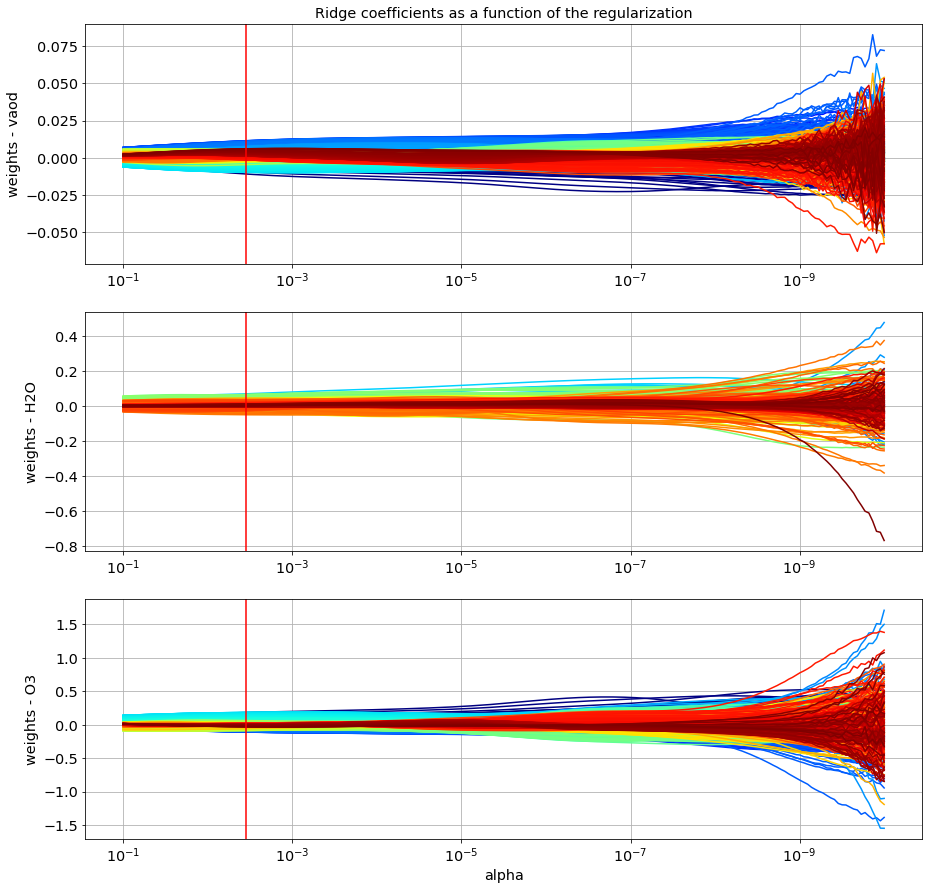

In [67]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.axvline(x=alpha_ridge,color='red')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.axvline(x=alpha_ridge,color='red')
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.axvline(x=alpha_ridge,color='red')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [68]:
from sklearn import linear_model

In [69]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [70]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0169794187972323, tolerance: 0.21899999999999956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3285992721444262, tolerance: 0.21899999999999992
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.73418438072436, tolerance: 0.2190000000000001
  model = cd_fast.enet_coordinate_descent(


Coefficients: 
 [[ 7.74126335e-01  4.20228020e-01  1.91571469e-01 ... -6.39728172e-03
  -5.61479368e-03 -4.95221700e-03]
 [-1.26293770e-02  5.03998849e-03  8.05542051e-03 ... -1.52144156e-03
  -2.53470536e-04 -7.51899884e-04]
 [-1.14920538e+01 -7.29604989e+00 -3.29961060e+00 ...  1.39620523e-01
   1.28783381e-01  1.36267689e-01]]
Mean squared error: 0.03574
Coefficient of determination: 0.96655
Explained variance: 0.96656


In [71]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6018864679579173, tolerance: 0.21899999999999956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.3591668499899, tolerance: 0.2190000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6018864679578848, tolerance: 0.2189999999999995
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.40399750551373, tolerance: 0.219
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6117997895526275, tolerance: 0.21899999999999956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.49270109466075, tolerance: 0.2190000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9835848502968191, tolerance: 0.21899999999999992
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.7703378592293, tolerance: 0.219
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8680997149042415, tolerance: 0.21899999999999956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.615222879728929, tolerance: 0.21899999999999992
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.4270636941329, tolerance: 0.2190000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30967229564549603, tolerance: 0.2189999999999995
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/l

<Figure size 1080x1080 with 0 Axes>

In [72]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [73]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

0.0012742749857031321

0.0012742749857031321

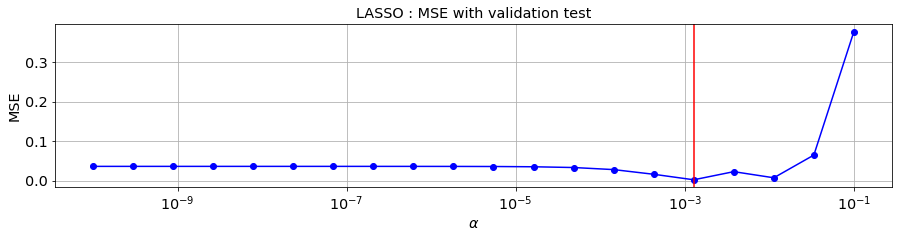

In [74]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
alpha_lasso

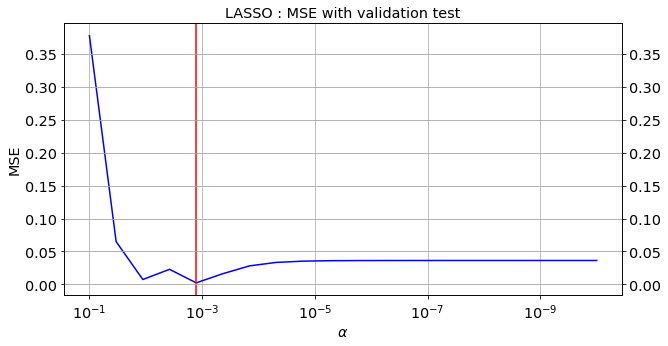

In [75]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.grid()
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

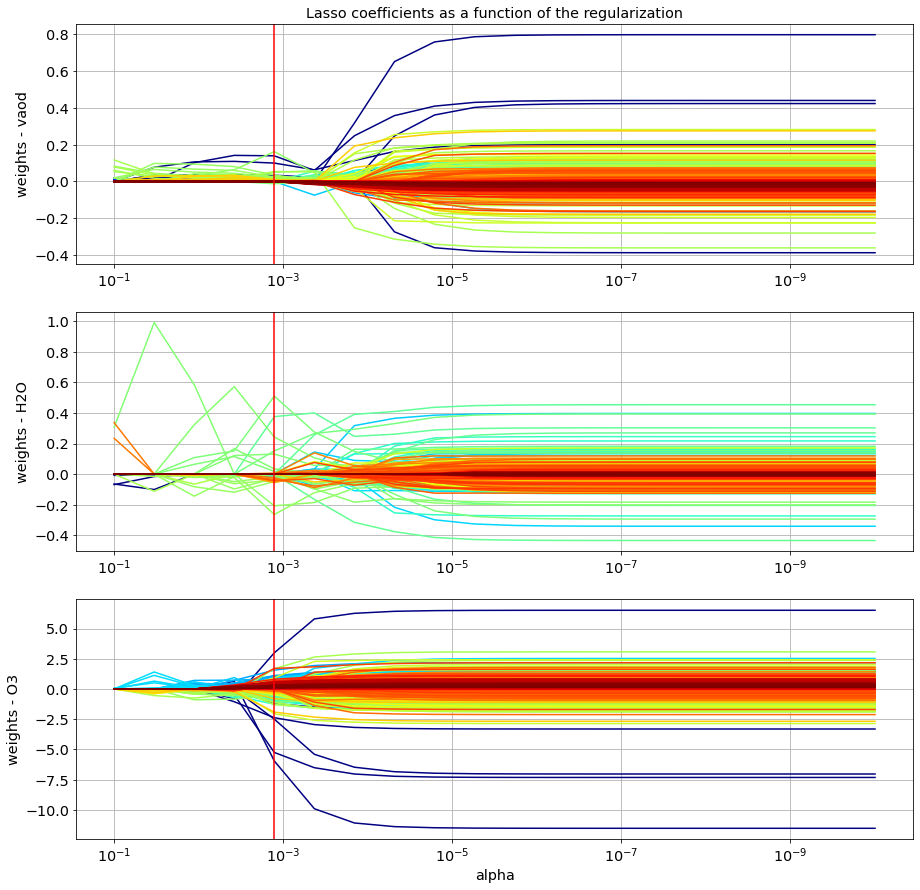

In [76]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.axvline(x=alpha_lasso,color='red')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.axvline(x=alpha_lasso,color='red')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.axvline(x=alpha_lasso,color='red')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [77]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [78]:
nsamples_train=np.arange(10,nb_tot_train,10)
nsamples_test=np.arange(10,nb_tot_test,10)

### Leraning curves for linear regression

In [79]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [80]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit on trainning sample    
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
    
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
                                        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
         MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 

    all_MSE_train[count]=MSE_train
    
    all_MSE_test_full[count]=MSE_test_full                                    
                                        
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

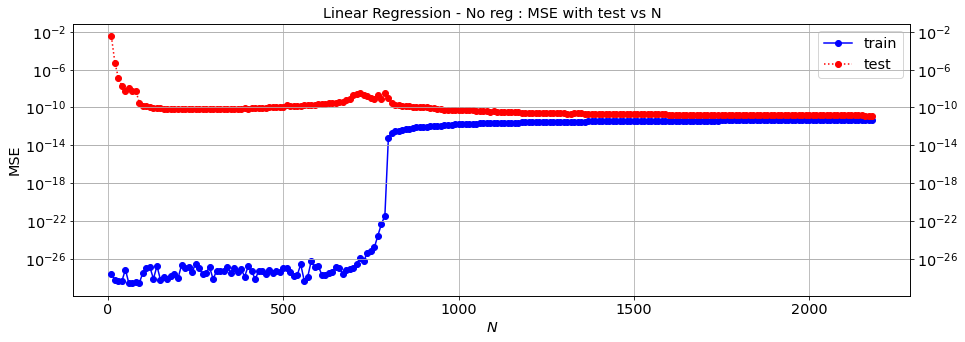

In [81]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r:o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [82]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [83]:
alpha_ridge

0.003570785964900463

In [84]:
alpha_ridge=1e-4

In [85]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit on traiinig set
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
        
    
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
        
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.06908e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04529e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.43766e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.5698e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAl

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2523e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.23308e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11951e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09779e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAl

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.82904e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.17724e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.87942e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.32396e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-c

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.77449e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.72714e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.22129e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.73794e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-c

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.59117e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.45866e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.38797e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41689e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-c

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.21388e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


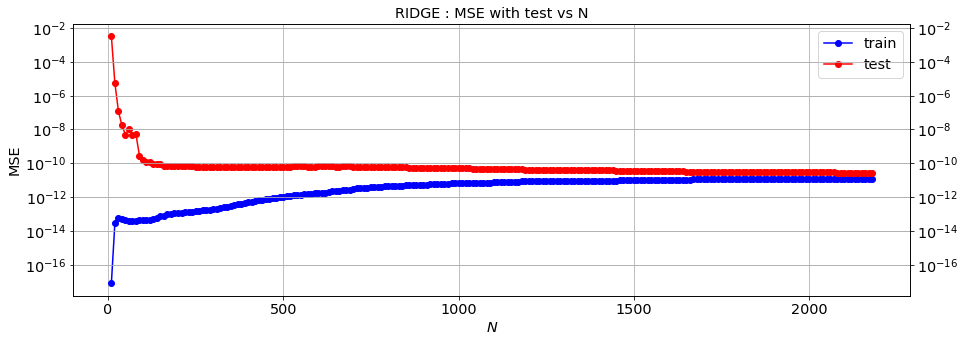

In [86]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [87]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [88]:
alpha_lasso

0.0012742749857031321

In [89]:
alpha_lasso_min

0.0012742749857031321

In [90]:
alpha_lasso_0=1e-3

In [91]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
     
    # fit on trainning sample
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
        
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)  
    
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013303441440345766, tolerance: 0.0009938346153402725
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000910194233257707, tolerance: 0.0003225237752955068
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8137426728413905, tolerance: 0.0007725971819792289
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.808216277964682, tolerance: 0.012145037446577902
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012264365923906976, tolerance: 0.008142987441284295
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07541108955138451, tolerance: 0.00812913824662196
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.61193454423805, tolerance: 0.019685741270984956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020123094751628087, tolerance: 0.013711322409924146
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18059863905922116, tolerance: 0.02025414488473681
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/s

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.794583035491016, tolerance: 0.028491313334467847
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033544714543479515, tolerance: 0.022481833506235303
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.315015013769564, tolerance: 0.03246617915714822
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.12080385515416, tolerance: 0.037637223142101356
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04516909674262217, tolerance: 0.03013450158631399
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41830597090321564, tolerance: 0.04280993391897208
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.26238924708417, tolerance: 0.044430385655122556
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05947659230489406, tolerance: 0.0393663093573285
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5186534838715442, tolerance: 0.05330516889811088
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklea

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.86626473983861, tolerance: 0.051854986976854686
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07453640293770011, tolerance: 0.0506570731459987
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6128155429564104, tolerance: 0.06146579754929884
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/skle

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.69421119932461, tolerance: 0.06577120519183255
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08693019797601849, tolerance: 0.05916829786378553
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6673504993078578, tolerance: 0.06902811367843459
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/skle

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.7497784066833, tolerance: 0.07551454733317449
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19925154391641492, tolerance: 0.06948579172366368
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7325567640471015, tolerance: 0.0782700145305142
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.48708263877342, tolerance: 0.08674510919730619
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20809988122213266, tolerance: 0.07752192382300878
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8203950129815019, tolerance: 0.09029123797647098
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/skle

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.5073789328095, tolerance: 0.09597655127987578
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2524382531630583, tolerance: 0.08806511256197627
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9818290437782383, tolerance: 0.09719099376024493
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.7519978292251, tolerance: 0.10760705576432074
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2771590559449329, tolerance: 0.09787616872772284
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0129342298465032, tolerance: 0.10434235654107803
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.04134920075464, tolerance: 0.11649177295854116
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30112981769081115, tolerance: 0.1054822360518537
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.076122062636502, tolerance: 0.11282797833379354
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.82331119788336, tolerance: 0.12534127102995843
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32413249965752955, tolerance: 0.11351713202263919
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0855601091745064, tolerance: 0.12143211506466174
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/skle

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.90841073396797, tolerance: 0.13526014370355466
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3522383019862555, tolerance: 0.12421048344663498
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1892012169491166, tolerance: 0.1295201275423152
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.7572315351305, tolerance: 0.14528677445997315
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3686790327051235, tolerance: 0.1341038582483175
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.243299552393801, tolerance: 0.13452387043328914
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291.54683737614204, tolerance: 0.15284432121231026
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3916288552510339, tolerance: 0.14300906171010694
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2400699094690715, tolerance: 0.1419196878637579
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.00186744727864, tolerance: 0.16013959539198816
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4220687676591661, tolerance: 0.14931474540569026
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.295941503085781, tolerance: 0.15330580446296208
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.88643519773314, tolerance: 0.16758166364743
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44559004131897156, tolerance: 0.15805850192554774
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3415624445575902, tolerance: 0.16041830332726556
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.1998626465641, tolerance: 0.17564569840021674
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4709091346291384, tolerance: 0.1687520104135682
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4797968531184527, tolerance: 0.16862595079911513
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359.3938936307568, tolerance: 0.18591605313367982
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5042236665870174, tolerance: 0.17717484159852864
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.56705706553364, tolerance: 0.18378727916175605
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.12199372140265, tolerance: 0.19568297973458584
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5315526632319346, tolerance: 0.1854053533351138
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.766183892093911, tolerance: 0.19323605396335944
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.69624443071297, tolerance: 0.20109064634581797
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5569839477001823, tolerance: 0.19489824005169173
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.796473931099229, tolerance: 0.19927561155868115
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410.79647795373666, tolerance: 0.2083534102595199
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5830083791164334, tolerance: 0.20369904181930829
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8700215915087823, tolerance: 0.2072301798031992
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429.47591232486354, tolerance: 0.21601333377439988
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6111777548003992, tolerance: 0.2168339640728301
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9424700354826125, tolerance: 0.21482672470597886
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklear

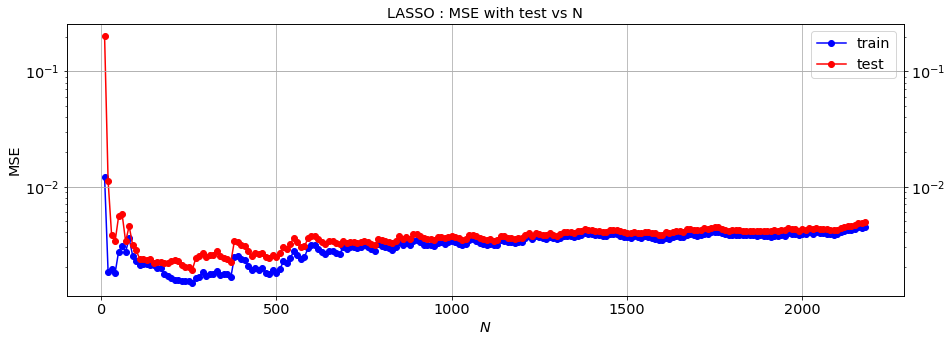

In [92]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [93]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [94]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/1852717475.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - No reg (no cloud)')

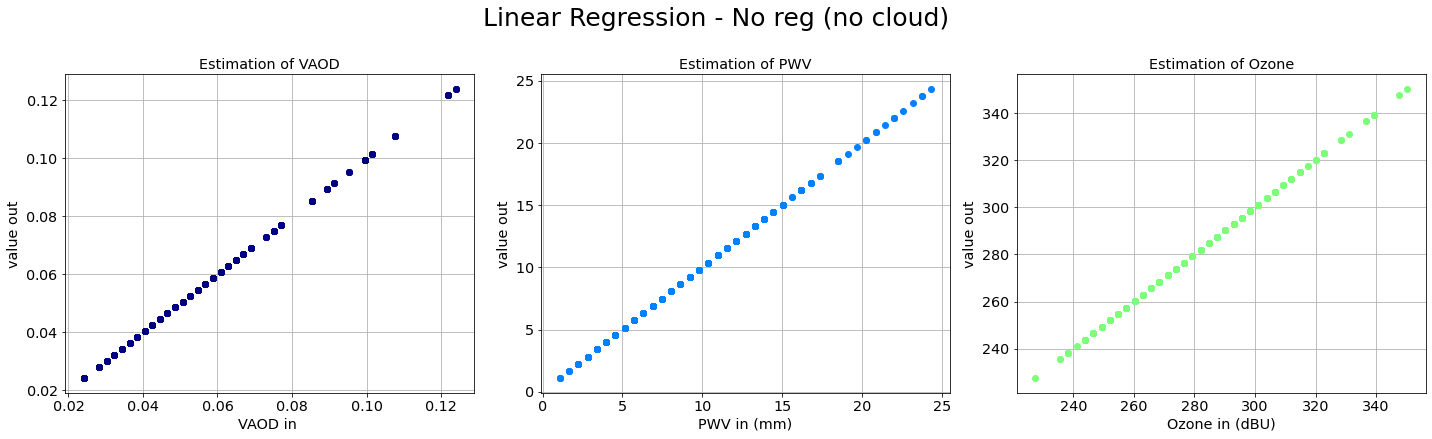

In [95]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/2999649130.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - No reg (no cloud)')

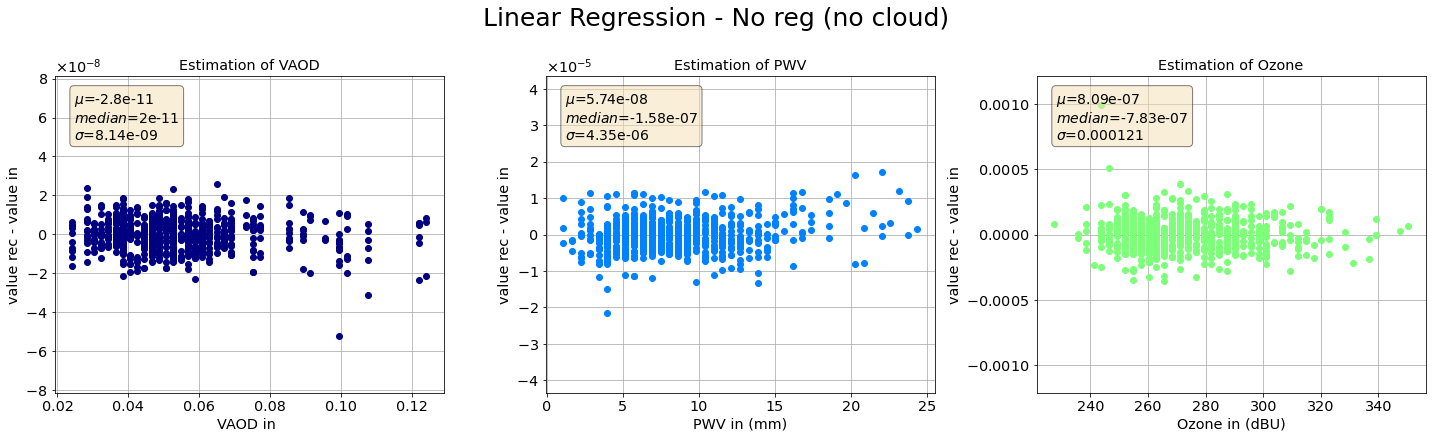

In [96]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/3335372137.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - No reg (no cloud)')

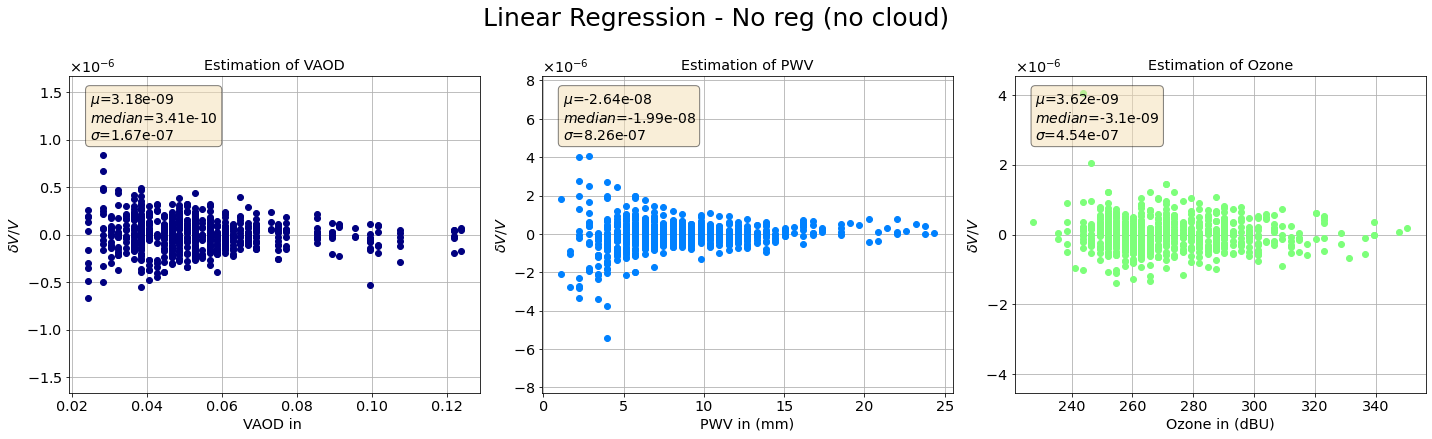

In [97]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)

## Ridge

In [98]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87251e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [99]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [100]:
ridge.coef_

array([[-0.01886153, -0.02468132, -0.01719273, ..., -0.01194293,
         0.01584057,  0.01201425],
       [ 0.05338833, -0.03668094, -0.02655401, ...,  0.09010673,
         0.07066628, -0.72335773],
       [ 0.05506166,  0.51382167,  0.31661962, ...,  0.18437435,
        -0.20346231, -0.4569747 ]])

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/1163148209.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Ridge (no cloud)')

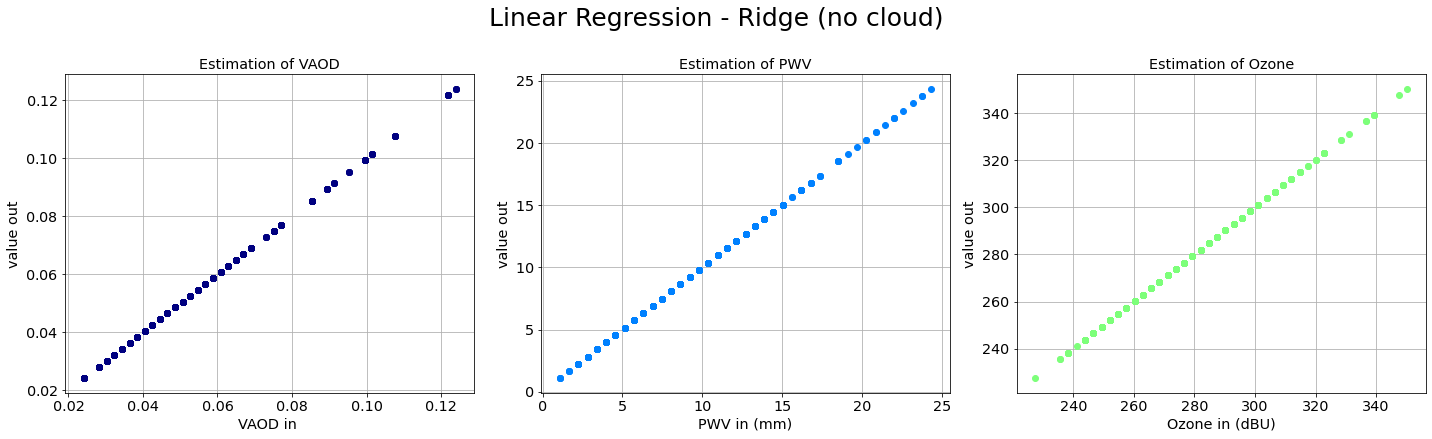

In [101]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/3703125899.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Ridge (no cloud)')

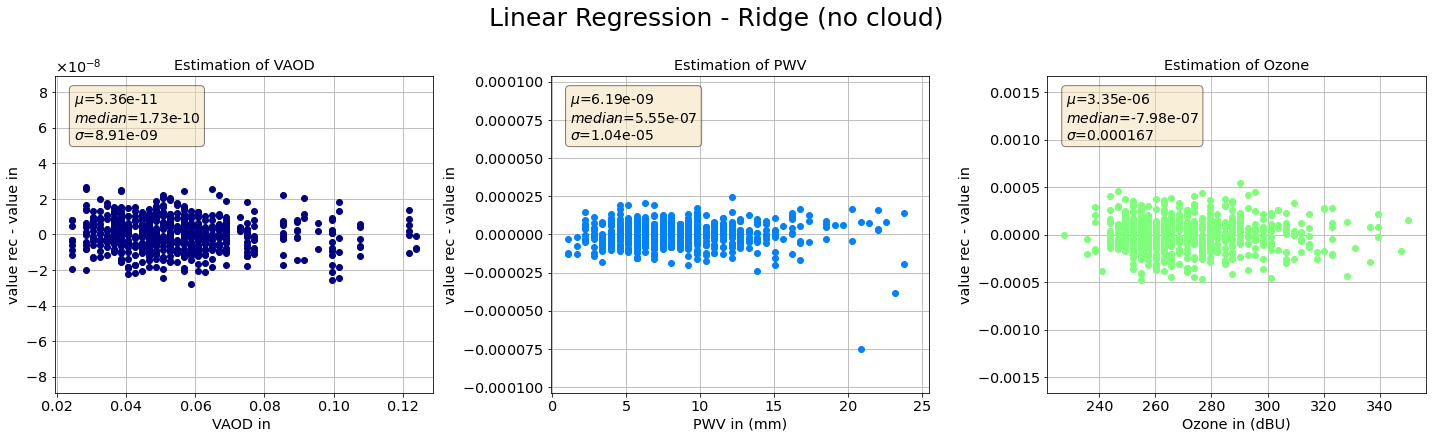

In [102]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/2226793434.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Ridge (no cloud)')

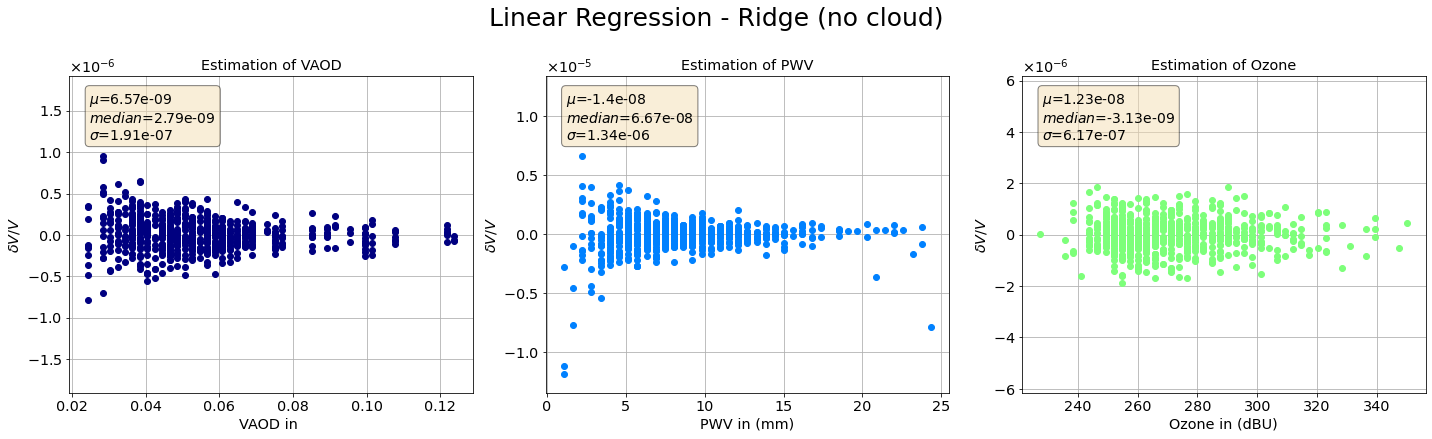

In [103]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (no cloud)",Y=1.1,fontsize=25)

## Lasso

In [104]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6165416562220858, tolerance: 0.21899999999999956
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.092751717488377, tolerance: 0.21899999999999992
  model = cd_fast.enet_coordinate_descent(
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.72601990589794, tolerance: 0.2190000000000001
  model = cd_fast.enet_coordinate_descent(


In [105]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00483
Coefficient of determination: 0.99547
Explained variance: 0.99547


/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/3559568607.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Lasso (no cloud)')

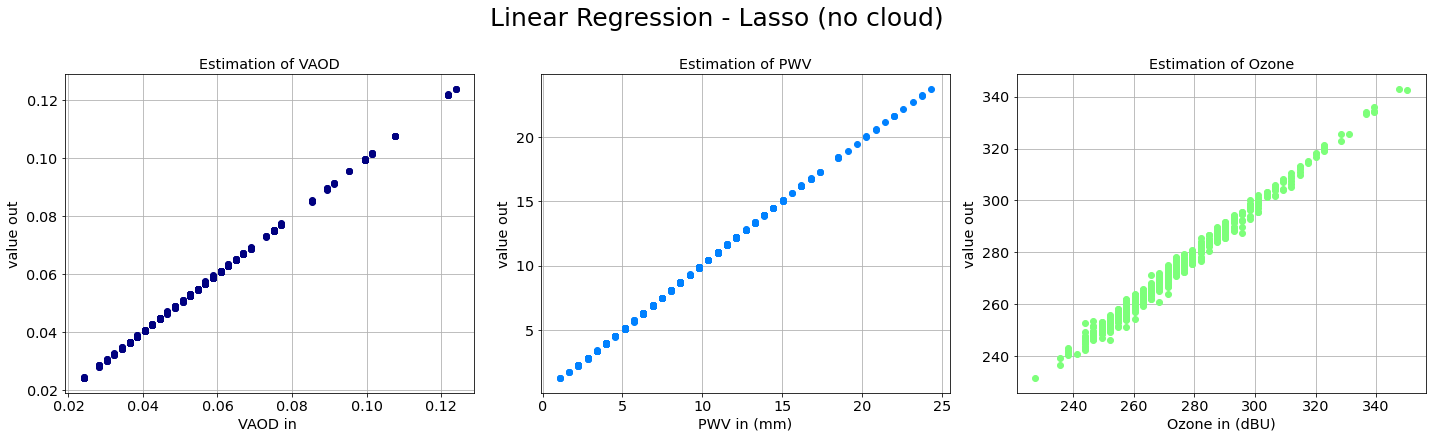

In [106]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)



/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/2986593490.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Lasso (no cloud)')

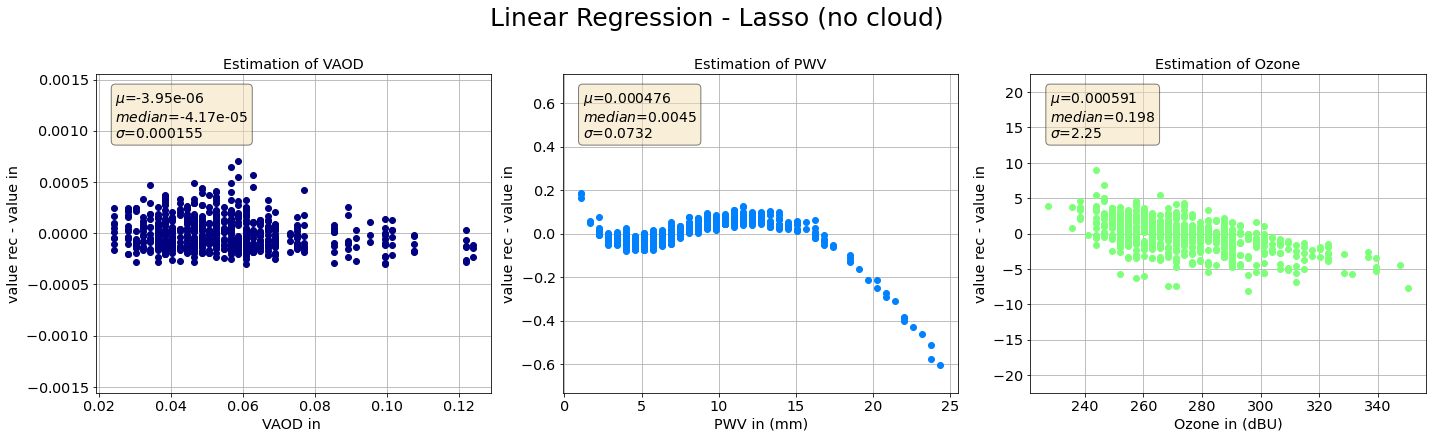

In [107]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_92627/3408319629.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)


Text(0.5, 1.1, 'Linear Regression - Lasso (no cloud)')

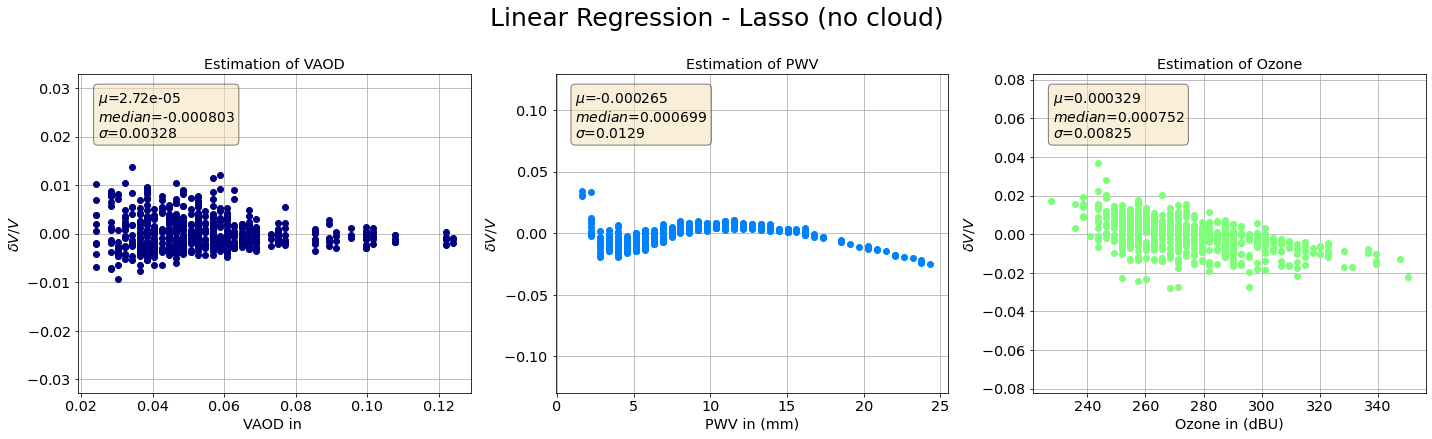

In [108]:
fig=plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(131)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(132)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(133)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (no cloud)",Y=1.1,fontsize=25)